In [ ]:
#https://stackoverflow.com/questions/47732102/unknown-output-of-opencvs-calcopticalflowfarneback

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import os
import seaborn as sns
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


import scipy as sp
from scipy import signal

In [51]:
# in windows: "G:/Other computers/My MacBook Air/thermal-project-data/cycling"
# in mac: "../../../Documents/thermal-project-data/cycling/"
fileToRead = []
for root, dirs, files in os.walk("G:/Other computers/My MacBook Air/thermal-project-data/cycling"):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('.MP4'):
            # print whole path of files
            fileToRead.append(os.path.join(root, file))
    
for file in fileToRead:
    print(file)

In [2]:
#testFile = ['G:/Other computers/My MacBook Air/thermal-project-data/cycling/split/20221014T111320-clip3.MP4'] #prasoon
#testFile = ['C:/temp_data/20221014T111320-clip3.MP4'] #prasoon
#testFile = ['G:/Other computers/My MacBook Air/thermal-project-data/cycling/split/20221013T141554-clip2.MP4']
# 20221014T111320-clip3.MP4 - high movment:
testFile = ["../../../Documents/thermal-project-data/cycling/split/20221014T111320-clip3.MP4"]

In [3]:
frameWidth = 1080
frameHeight = 1440

In [4]:
# some global variables

# pixel_t is a list which store n number of lists where each list is of size image_height*image_width. n is the number of frames
# the elements inside the list are pixel intensity values at that pixel
pixel_t = []

# a tuple, which stores two list. These lists corresponds to flow vector along x and y axis.
prev_delta = ()

# this variabel keeps a track of the number of times track_pixel() has run. Each list is of size image_height*image_width
count_track_pixel = 0;

# a 2D array to store the pixel history over time (or over frames) 
# the starting pixels are ofcourse 0 to height*width of the image

#pixel_hist_y, pixel_hist_x = np.mgrid[0:frameWidth:1, 0:frameHeight:1]
#pixel_hist_y = np.array([pixel_hist_y],dtype=np.int32) #make it a 3d array
#pixel_hist_x = np.array([pixel_hist_x],dtype=np.int32)
pixel_hist_y, pixel_hist_x = np.mgrid[0:frameHeight:1, 0:frameWidth:1].reshape(2,-1).astype(int)
pixel_hist_x = np.array([pixel_hist_x])
pixel_hist_y = np.array([pixel_hist_y])

#pixel_hist_x = np.array([np.arange(0,frameWidth*frameHeight,1)])
#pixel_hist_y = np.array([np.arange(0,frameWidth*frameHeight,1)])

def track_pixel(img, flow, step=1):
    '''
    All we need is the current pixel location given the output by optical flow
    
    '''
    # we will change global variables
    global pixel_t,count_track_pixel,prev_delta,count_track_pixel,pixel_hist_x,pixel_hist_y, poi_DOF_x, poi_DOF_y, current_y, current_x;
    
    # get the height and the width of the frame
    h, w = img.shape[:2]
    y_, x_ = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    
    # only on the first run
    if count_track_pixel == 0:
        print("First Frame Processed")
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    else:
        y, x = current_y, current_x
        # the line below does not make sense and needs to be removed, Currently its there so that I can compare the result
        # y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
        
    fx, fy = flow[y_,x_].T
    fx = fx/(1/fps)
    fy = fy/(1/fps)
    print(fx)
    print(fy)
    print("\n\n\n\n")
    
    
    # update prev_delta for the next frame
    prev_delta = (fx, fy)
    
    # both of these variable tell me the location of pixel in the current frame.
    current_x = x-fx
    current_y = y-fy
    
    # given the the flow vector is a float, we convert it to int so that we can have a pixel index
    current_x = np.int32(current_x)
    current_y = np.int32(current_y)
   
    #status = all((current_x >= 0) & (current_x <= 549)) & all((current_y >= 0) & (current_y <= 549))
    
    # clip pixels so that out of range pixels are not considered. We dont want pixels that are negative or greater than the 
    # size of the image
    current_x_ = np.clip(current_x, 0, frameWidth-1)
    current_y_ = np.clip(current_y, 0, frameHeight-1)
    
    # These variables will keep track of the initial point of LK with respect to global flow
    poi_DOF_x = current_x_[(int(y_i)*frameWidth+int(x_i))]
    poi_DOF_y = current_y_[(int(y_i)*frameWidth+int(x_i))]
    
    
    # store the upated pixel location for each frame in the global array
    pixel_hist_x = np.append(pixel_hist_x, [current_x_], axis=0)
    pixel_hist_y = np.append(pixel_hist_y, [current_y_], axis=0)
    
    # corresponding intensity value for the previous frame
    pixel_t.append(img[current_y_,current_x_])
        
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    count_track_pixel +=1
    
    return img_bgr    

def draw_flow(img, flow, step=16):
    
    # get the height and the width of the frame
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    # line[0] denotes information of the first pixel where -
    # - line[0][0][0] denotes the current pixel location of the 
    # - line[0][1][1] denotes the previous pixel location (curret loc-velocity vector)
    lines = np.int32(lines + 0.5)
    
    # lines[:,0,0] all x locations of current frame 
    # lines[:,0,1] all y locations of current frame
    # lines[:,1,0] all x locations of prev frame 
    # lines[:,1,1] all y locations of prev frame
    
    
    #pixel_loc_x = lines[:,1,0].clip(min=0,max=549)
    #pixel_loc_y = lines[:,1,1].clip(min=0,max=549)
    
    #pixel_t.append(img[pixel_loc_x,pixel_loc_y])
    
    #print(img[pixel_loc_x,pixel_loc_y]) 
    
    #print(lines[:,0,0]) # does not change
    #print("\n\n\n")
    
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines[50:90], 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr

def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

In [5]:
# event to register click for the lucas kanade optical flow
def click_event(event, x, y, flags, params):
    global old_points, first_point;
    if event == cv2.EVENT_LBUTTONDOWN:
        old_points = np.array([[x,y,]], dtype=np.float32)
        first_point = old_points
        
# lucas kanade params
lk_param = dict(winSize=(350,350), maxLevel=24, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))

In [6]:
#optflow_params = [0.000001, 1, 10000, 1, 1, 1.2, 0]
optflow_params = [0.5, 500, 2, 3, 5, 1.2, 0]

# variable to just test
flow_global = 0;
bigFrameCount = 0;
bigfailedFrameCount = 0

# this variable will store the intensity hostory of the tracked pixel as per LK algorithm
# the first value in this list is of the point selected by the user
intensity_xy = []
pixel_hist_x_lk = []
pixel_hist_y_lk = []


# Load the cascade
#haarcascade_frontalface_alt2.xml
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('haarcascade_mcs_nose.xml')
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

for file in testFile:
    print("\n\nProcessing = {}".format(file))
    cap = cv2.VideoCapture(file)
    # get the total frame as per opencv2
    totalFrame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # get the frame rate
    fps = cap.get(cv2.CAP_PROP_FPS)
    print("Total number of frames = {}".format(totalFrame))
    # if multiple files are processed than this variable tells the total number of frames
    bigFrameCount+=totalFrame;
    # we need to forward atleast one frame so that we have a 'previous' frame for optical flow  
    fastForwardFrame = 0
    plotImages = False
    # keep a tab of the frame count
    frameNumber =  0 if fastForwardFrame == 0 else fastForwardFrame
    failedFrameCount = 0
    # move frame that we want to fast forward
    while fastForwardFrame:
        correct,prev_frame = cap.read()
        prev_frame_gray = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
        fastForwardFrame-=1;
    
    # This variable tells how many frames to process? By default its all frame i.e. totalFrame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    NosFrame = totalFrame
    # NosFrame = totalFrame
    # this variable will be reduced after each frame is processed
    frameLeft = NosFrame
    if plotImages:
        fig, ax = plt.subplots(round(np.sqrt(NosFrame)),round(np.sqrt(NosFrame)), figsize=(45,45))
    j=0;i=0
 
    correct = True
    while frameLeft and correct:
        # read the first frame of the video
        correct,frame = cap.read()
        if correct:
            # convert the first frame to grayscale
            old_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            
            # get the size of the frame
            height, width, channel = frame.shape
            
            # create a all-zeros mask, we are doing this to get all the pixels covered by the circle
            # mask = np.zeros((height, width), np.uint8)
            
            if frameNumber%100 == 0:
                print("\nDone {} out of {}".format(frameNumber, totalFrame))
                print("Failed Frame Till Now {}".format(failedFrameCount))

            # Create a mask image for drawing purposes
            # mask = np.zeros_like(old_gray)

            #roi = old_gray[y:y+h,x:x+w]
            roi = old_gray

            # calculate dense optical flow of the ROI only if this ROI is not the first ROI that we are processing
            # We need to be on the second frame to have a flow vector from the first frame
            
            #cv2.imshow("Frame", roi)
            if frameNumber != 0:
                flow = cv2.calcOpticalFlowFarneback(roi_old,roi, None, *optflow_params)
                flow_global = flow
                # LK: get the new points for optical flow
                new_points, status, error = cv2.calcOpticalFlowPyrLK(roi_old,roi, old_points, None, **lk_param)
                # LK: update the old points to new points
                old_points = new_points
                # make arrangements to plot the points
                x,y = new_points.ravel()
                frame = track_pixel(roi, flow, 1)
                cv2.circle(frame, (int(x_i),int(y_i)),5,(0,0,255),-1)
                cv2.circle(frame, (int(x),int(y)),2,(255,0,0),-1)
                cv2.circle(frame, (int(poi_DOF_x),int(poi_DOF_y)),2,(0,255,0),-1)
                cv2.imshow('flow', frame)
                # store the intensity of the point tracked by LK
                intensity_xy.append(roi[int(x),int(y)])
                pixel_hist_x_lk.append(x)
                pixel_hist_y_lk.append(y)
            else:
                cv2.imshow('image', roi)
                cv2.setMouseCallback('image', click_event)
                cv2.waitKey(0)
                
                # LK:optical flow pixel click
                x_i, y_i = first_point.ravel()
                intensity_xy.append(roi[int(y_i),int(x_i)])
                pixel_hist_x_lk.append(x_i)
                pixel_hist_y_lk.append(y_i)
                # this is the first frame and our frame of interest to indicate the ROI.
                # LK: show the first frame, so the the user can click the pixel of interest

                # LK: wait infinitely until a key is pressed.
               
                print("Initial Pixel X = {}, Y = {}".format(x_i, y_i))
                
            roi_old = roi
            
            #key = cv2.waitKey(1) 
            key = cv2.waitKey(int((1/fps)*1000))
            if key == 27 or key == ord('q'):
                break

            if plotImages:    
                ax[j,i].imshow(roi)
                ax[j,i].set_title("Frame No. {}".format(frameNumber))
                i+=1;
                if i==round(np.sqrt(NosFrame)):
                    i=0
                    j+=1


            frameLeft-=1; frameNumber+=1
   
        else:
            cap.release()
            cv2.destroyAllWindows()
            print("Gracefully Closed, Error!")
            break;
            
    bigfailedFrameCount+=failedFrameCount
    cap.release()
    cv2.destroyAllWindows()
    print("Completed = {}".format(file))



Processing = ../../../Documents/thermal-project-data/cycling/split/20221014T111320-clip3.MP4
Total number of frames = 525.0

Done 0 out of 525.0
Failed Frame Till Now 0
Initial Pixel X = 567.0, Y = 591.0
First Frame Processed
[ 1.4833522e-08  1.0833669e-06  4.2929355e-06 ...  3.4982403e-07
 -1.5926489e-07 -4.3851567e-09]
[ 3.5795614e-10 -5.3063751e-08 -5.6201787e-07 ... -2.3924199e-06
 -9.5367761e-07 -7.8461211e-09]





[ 1.4833520e-08  1.0833669e-06  4.2929355e-06 ... -1.4407527e-06
 -9.2273481e-08  3.8381032e-09]
[ 3.5795736e-10 -5.3063751e-08 -5.6201787e-07 ... -9.0010153e-06
 -4.2529402e-07  5.0869346e-08]





[ 1.4833522e-08  1.0833669e-06  4.2929350e-06 ...  4.3459667e-07
 -7.2479294e-09 -1.4465164e-09]
[ 3.5795761e-10 -5.3063751e-08 -5.6201793e-07 ... -2.1964161e-06
 -1.6926772e-07  6.1066102e-10]





[1.8203380e-26 2.6174413e-24 2.2738348e-06 ... 3.0509980e-07 3.9221028e-08
 2.2127529e-09]
[ 4.8361518e-26  9.6260926e-24 -6.3906629e-07 ...  1.0598070e-06
  3.4415535e-07 -2.

[-1.5687486e-24 -2.3622031e-20 -3.1549394e-18 ... -2.4744971e-09
 -2.0700931e-08  1.2290777e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.0445386e-08
 -5.9715202e-09 -2.0860821e-10]





[-4.7183068e-24 -7.0929626e-20 -9.5053913e-18 ...  1.2355324e-07
 -6.4914850e-08  1.6293783e-10]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.4967579e-08
 -5.3469378e-08  1.0356015e-11]





[-6.3808442e-22 -2.2166461e-18 -9.4173527e-17 ...  1.4208258e-07
  3.0065628e-08 -2.9077039e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0008405e-07
  1.7234368e-07 -2.4206726e-10]





[ 1.4650197e-39  2.8418545e-18  1.2745288e-16 ... -8.9675081e-07
 -5.0008333e-07  3.8236320e-11]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.0867221e-06
 -4.6347645e-07 -2.3268693e-10]





[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -4.1542805e-08
 -4.4758842e-08 -2.9371596e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.2419433e-08
  1.7900005e-07 -3.8646561e-10]





[ 2.5

[ 1.7413893e-15  9.5167316e-14  2.1170662e-13 ...  9.7935747e-08
 -1.2065503e-07  1.7883840e-09]
[-7.0712025e-14 -2.5952627e-11 -5.6423765e-11 ... -2.0005565e-07
 -5.8988245e-08  1.5879914e-08]





[ 5.1414798e-15  1.2155958e-12  3.7174161e-12 ... -1.7231548e-07
 -2.7242761e-08 -1.4640784e-10]
[ 3.8076037e-16  3.1594527e-12 -8.8896555e-13 ...  6.2535264e-08
  1.1757801e-08 -3.7074205e-10]





[4.5169256e-21 6.7464169e-17 8.9965292e-15 ... 1.4871777e-07 1.5033631e-07
 3.2534082e-09]
[ 4.5529988e-21  5.5004900e-17  5.6102482e-15 ...  1.9057476e-08
 -1.8972132e-08  2.4354263e-10]





[-0.0000000e+00 -1.4148351e-23 -8.9488947e-21 ... -3.1193235e-07
  4.5590028e-08 -2.2833722e-09]
[-0.0000000e+00 -2.9819631e-41  6.6267552e-37 ...  9.3421995e-08
 -5.3766328e-08 -7.9850676e-10]





[ 0.0000000e+00  2.3539103e-23  1.4886587e-20 ... -1.8463398e-07
 -4.6433141e-10 -1.8231763e-10]
[ 0.0000000e+00  9.7440690e-41 -2.1535341e-36 ... -1.0126239e-08
 -2.3570461e-08  9.6666989e-12]





[ 0.0000000

[ 2.4208712e-36  1.2883472e-36 -4.0602800e-22 ... -8.3867269e-07
 -2.2732372e-06 -3.7003385e-08]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.1863238e-07
 -3.7238567e-07 -2.6560985e-09]





[ 3.6125304e-34  9.6847545e-35 -4.0602800e-22 ...  4.4378712e-08
  5.8942792e-08 -6.0542987e-10]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6943554e-06
 -2.2133193e-08 -2.0874322e-10]





[ 3.6125304e-34  9.6847545e-35 -4.0602800e-22 ... -2.4287494e-06
 -1.4778350e-07 -7.9489293e-10]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  9.0490466e-06
  1.8190373e-06 -5.2514046e-09]





[ 2.7440306e-34  7.3298794e-35 -4.0602800e-22 ...  4.9944970e-07
 -7.9124924e-08 -1.3994465e-08]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.4572337e-05 1.4549978e-07
 6.9135306e-09]





[ 3.6125304e-34  9.6847545e-35 -4.0602800e-22 ... -6.0776287e-08
 -3.4033373e-08  3.4444505e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  1.0966368e-07
  8.9633874e-09 -3.2901282e-10]





[ 3.0838571

[ 1.5238100e-09 -1.0184289e-08 -1.9356927e-08 ...  2.9989127e-07
  4.1439719e-07 -7.0339290e-10]
[ 8.0904078e-10  4.9707277e-10 -5.1723896e-09 ...  1.8617433e-05
  6.1972833e-06  6.2649534e-09]





[-1.3227427e-09 -2.8946346e-08  1.8781138e-08 ...  1.0303654e-06
  9.2637504e-07  7.8691720e-09]
[-1.0256043e-08 -2.8644843e-07 -5.2475252e-07 ...  1.0209023e-05
  4.5345109e-06  1.6233045e-09]





[ 3.7722504e-08  8.5837961e-08 -2.3851030e-07 ... -9.1877547e-07
  1.0772198e-07 -4.3535455e-09]
[ 4.4984510e-08  7.4260737e-07  1.1167971e-06 ... -4.4060201e-07
  1.4483232e-09 -3.1607789e-10]





[-1.7400713e-09 -3.5058218e-08 -2.2703061e-08 ... -9.4437056e-08
  1.3693077e-08 -3.4199239e-09]
[-5.0136846e-09 -2.4808283e-08 -2.2450868e-08 ... -8.7874980e-07
 -2.6481524e-07  6.6273720e-10]





[ 1.9286240e-08  1.9206059e-08 -2.5701500e-16 ... -2.2337287e-07
 -2.7841589e-08  8.8058977e-10]
[ 1.4616778e-08  3.9787029e-08  1.3342617e-16 ... -1.4643969e-07
 -2.7406685e-08  4.7329018e-10]





[ 1.9

[ 0.00000000e+00  2.09217986e-18  7.34376401e-16 ... -1.87363995e-07
 -1.16607694e-07  9.24014754e-10]
[ 9.5302309e-42  2.2415031e-15  3.7505480e-12 ... -2.2710875e-08
  9.5838722e-08 -9.1986602e-10]





[ 4.1853489e-24  7.3421651e-24  6.5534268e-28 ... -3.6208810e-08
 -1.5192731e-07  6.5181482e-09]
[ 2.72780947e-36  1.04339666e-20 -4.46735307e-23 ... -2.26168837e-07
  2.94299099e-07  8.04537095e-08]





[ 4.9045446e-44  2.1202602e-32  9.7566835e-29 ... -4.1589242e-08
 -2.8202972e-08  2.0844042e-09]
[ 1.0269136e-40 -2.8583599e-29 -6.5944216e-24 ... -8.4531031e-08
 -9.8039287e-08  4.9792943e-09]





[ 4.9045446e-44  2.1202602e-32  9.7566835e-29 ...  1.9489772e-08
  1.2921419e-08 -1.7027638e-10]
[ 1.0269136e-40 -2.8583599e-29 -6.5944216e-24 ...  1.1703709e-07
  9.3211661e-09  2.4910637e-10]





[4.9045446e-44 2.1202602e-32 9.7566835e-29 ... 4.8734648e-08 1.6895184e-08
 2.8439480e-11]
[ 1.0269136e-40 -2.8583599e-29 -6.5944216e-24 ...  1.5784804e-10
 -1.7051953e-09 -2.1051048e-10]






[ 7.4076580e-18 -5.1268793e-17 -4.4577602e-16 ... -4.3133092e-08
 -2.5165761e-07  2.7632971e-10]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  9.4418795e-08
  8.0365609e-08 -4.5786538e-10]





[ 7.4076580e-18 -5.1268793e-17 -4.4577602e-16 ...  2.6122581e-07
  1.0209330e-07 -2.4532056e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  4.7818983e-08
 -1.5886438e-10  5.3308385e-10]





[-4.0098901e-19  3.1816255e-18 -9.4837872e-17 ...  1.1316585e-07
 -9.3308955e-08  8.7389362e-10]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  8.3122600e-08
 -1.8465173e-08 -1.4725997e-10]





[ 5.6522236e-18  6.5332869e-17  6.7656293e-17 ... -4.0004747e-07
 -1.2223347e-07  1.8900020e-10]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.2566282e-08
 -2.2182045e-08  3.7902051e-10]





[ 1.3390032e-15 -3.4353837e-14 -1.0074565e-13 ...  2.7368407e-07
 -2.1054194e-07 -2.3698496e-09]
[ 3.0491634e-12  2.5689852e-12  5.0330460e-12 ...  1.1941294e-08
 -1.2171601e-08  9.6725850e-10]





[ 5.7

[-1.9751985e-34 -6.3481142e-17 -3.8480618e-15 ... -2.7026958e-06
 -1.6818386e-06  1.3853924e-08]
[-2.0270447e-30 -1.5052093e-28 -2.0032184e-26 ... -2.9026140e-05
 -1.8430977e-05 -5.9954169e-07]





[ 1.0138773e-18 -5.7259652e-17 -3.6664499e-15 ... -1.2085402e-06
 -1.2047600e-06 -2.1382487e-09]
[-1.9488449e-30 -1.5022712e-28 -2.0030833e-26 ... -5.6923895e-06
 -3.8771368e-06 -8.8530694e-09]





[ 6.8890050e-18  3.9521965e-17 -1.5884527e-15 ... -3.9261789e-09
 -1.3433142e-07 -2.4023514e-09]
[2.8600593e-31 2.3549510e-30 4.1030827e-29 ... 2.1199294e-07 8.1954648e-09
 3.0637774e-11]





[-2.2549360e-12  3.2054772e-09  3.9174161e-08 ...  1.6317219e-09
  4.9974428e-08 -4.1319104e-11]
[-4.7846158e-11 -3.5751963e-08 -1.4181344e-07 ...  1.1876069e-06
  1.0640740e-07 -7.1771700e-09]





[ 1.0370687e-09 -9.0501592e-11 -4.6605093e-09 ... -1.2997504e-07
 -7.1322773e-07 -1.2765513e-08]
[ 2.0052264e-09  1.0146402e-08  2.2582647e-08 ... -9.7779818e-08
 -1.0757438e-09  1.9630725e-10]





[ 0.0000000

[2.9227616e-12 3.8788102e-09 7.7849847e-08 ... 3.4705516e-07 6.0465247e-08
 2.1990534e-09]
[-1.4077660e-10 -7.0977798e-08 -3.3269478e-07 ... -5.2842574e-07
  5.2758682e-09 -7.5349900e-11]





[ 1.3589991e-09  4.4643095e-08  1.7080044e-18 ... -1.9862919e-06
 -4.3755739e-07  9.8690371e-09]
[4.3449155e-10 5.8770073e-08 5.5945875e-19 ... 2.3351552e-06 6.9164560e-07
 2.1221190e-08]





[ 1.3589991e-09  4.4643095e-08  1.3729795e-18 ...  7.5945222e-06
  1.7437706e-06 -4.2648742e-09]
[ 4.3449155e-10  5.8770073e-08  8.6717050e-19 ... -7.5052463e-07
 -3.1954312e-07  2.1892305e-10]





[ 1.4131288e-11  1.2319784e-08  4.4464802e-08 ...  1.8692978e-07
 -1.8880921e-07 -1.3126291e-09]
[ 4.2398571e-10  3.0383674e-07  3.0918420e-06 ...  1.1348036e-06
  4.2855007e-07 -1.1219808e-08]





[1.5134448e-10 3.3413678e-09 1.0672454e-14 ... 7.2504456e-08 2.0798763e-07
 4.9834279e-09]
[ 9.86189741e-11  1.08282086e-08  2.04741606e-13 ...  1.73975423e-06
  7.22213099e-06 -4.98101116e-09]





[ 3.6150786e-19 -

[-2.0880361e-17 -1.9748188e-16  4.2278252e-16 ... -4.9604445e-08
 -2.7752117e-07  2.3480935e-09]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.2307871e-07 6.4423226e-08
 1.9822843e-10]





[ 2.2859757e-16  1.7334499e-16 -1.5512951e-15 ... -2.2131459e-07
 -4.4128534e-08  1.7213074e-08]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  4.1358980e-08
 -7.0184583e-09 -1.1312985e-09]





[ 2.9440838e-32  2.8658535e-32  1.3060077e-32 ... -6.1680758e-08
 -9.6183562e-08  1.0215014e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.0430751e-08
  2.5079792e-08 -9.9420722e-11]





[ 2.2859757e-16  1.7334499e-16 -1.5512951e-15 ... -2.7976600e-07
  2.1768179e-07 -7.1663391e-09]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 9.2693746e-08 2.4973778e-07
 3.8143189e-10]





[ 2.2859757e-16  1.7334499e-16 -1.5512951e-15 ... -1.3263238e-07
 -5.1807223e-07 -1.3020174e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.0961005e-07
  3.0141092e-07 -2.8316467e-09]





[ 2.0117321e-16  

[ 4.7005802e-20  2.0438687e-17  5.7225371e-16 ... -6.1704455e-09
 -1.2770246e-07 -1.1404814e-09]
[-1.7373449e-19 -2.2453563e-17 -4.1617132e-16 ... -5.6232931e-08
 -8.8069250e-09 -4.6524398e-10]





[-6.3064517e-13 -4.4350734e-12 -2.3620071e-12 ...  1.0954869e-06
  1.4319143e-07 -6.8011969e-09]
[ 5.2024943e-14 -6.8709725e-12 -3.6951048e-10 ...  7.3962374e-06
  2.4877866e-07 -2.7106368e-09]





[ 2.8372448e-18  4.0874862e-17  3.0365625e-17 ... -4.9061020e-07
 -1.5195775e-07  5.0788849e-09]
[ 6.63980946e-31  9.67976784e-29  3.71845024e-28 ...  8.52670468e-08
  1.02483796e-07 -1.20294663e-10]





[-5.0446745e-43 -2.5733585e-38  4.7098870e-32 ... -3.7052072e-08
 -3.9388919e-08  1.2780375e-09]
[ 1.9503272e-41  6.2060729e-35 -1.2340633e-30 ...  8.2231736e-07
 -1.6161776e-08  6.3654776e-10]





[-5.9740950e-15 -6.4114274e-12 -5.4889166e-11 ... -2.5547726e-07
  3.4375252e-09  5.0876192e-09]
[ 6.7492279e-16  6.4682977e-12  1.3236887e-12 ... -7.9823997e-07
 -2.8792787e-08 -4.2911513e-10]






[-9.7252129e-24 -1.4850249e-19 -2.0143615e-17 ...  1.6188449e-07
 -2.4054265e-07  3.3782012e-08]
[-0.0000000e+00  2.0469288e-38  2.3134754e-32 ... -7.1159269e-07
 -1.1932888e-06 -2.4417000e-08]





[-1.9939770e-23 -5.0172191e-20 -1.8312296e-18 ... -2.1438223e-07
 -3.1339425e-07  2.0233211e-09]
[-0.0000000e+00  8.7695763e-38  1.6009466e-32 ... -9.8197166e-09
  2.4934742e-08  1.4144725e-09]





[ 3.8256976e-25  5.7702985e-21  9.1275503e-19 ...  5.5375654e-07
 -6.6135946e-08  1.7389272e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1941522e-06
 -1.8476619e-07 -3.1885061e-10]





[-2.5929507e-18  8.0339057e-17  1.1080635e-15 ...  4.4668826e-07
 -1.5440088e-07 -3.7615377e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -2.6656964e-05
 -2.2609040e-06 -1.0751032e-09]





[ 3.1969697e-18 -5.0561551e-17 -3.6664499e-15 ...  9.8557609e-07
 -1.8853503e-09 -1.8864574e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.4738565e-06
  1.7371459e-08  1.8137659e-09]





[ 3.1

[ 4.2617118e-24  6.4299812e-20  1.9865331e-17 ...  2.4767607e-07
  2.3594581e-07 -3.8506407e-09]
[ 4.8179444e-41  1.4857174e-34  4.3283254e-31 ... -2.6577709e-07
  3.6544935e-07  4.8139612e-09]





[-4.5784950e-25 -1.0101594e-20 -6.2203358e-18 ...  3.8526623e-06
  5.0920340e-07 -6.0617995e-09]
[-1.35267341e-41 -4.54622440e-35 -1.32447721e-31 ...  8.36172603e-06
  2.35689186e-06 -1.05559685e-07]





[ 1.3031715e-23  1.9598840e-19  2.6057607e-17 ... -2.1335295e-07
 -3.0404138e-08 -1.2560394e-09]
[ 2.7987574e-40 -1.3828176e-33 -1.5527970e-29 ... -1.2216565e-08
  2.9259734e-08  2.9301577e-09]





[ 1.3031715e-23  1.9598840e-19  2.6057607e-17 ... -5.3134511e-07
 -2.3445797e-07 -1.3487799e-09]
[-1.4842553e-41 -1.3836966e-33 -1.5528021e-29 ...  1.3061388e-07
  7.9483335e-08 -2.5983735e-10]





[ 3.4292020e-24  5.1706556e-20  1.7940265e-17 ...  2.3500104e-07
 -4.1633371e-07 -5.6605147e-09]
[ 3.8932275e-41  1.1993299e-34  3.4846728e-31 ... -9.0577731e-07
  2.0022080e-07 -4.5930300e-09]






In [11]:
pixel_t = np.array(pixel_t)

In [115]:
# fiding the pixel of interest in a flattened array
# y*frameWidth+x
#595*frameWidth+569

In [10]:
pixel_hist_x.shape

(525, 1555200)

In [18]:
#pixel_hist_x[:,(int(y_i)*frameWidth+int(x_i))]

In [19]:
#pixel_hist_y[:,(int(y_i)*frameWidth+int(x_i))]

In [20]:
#np.array(pixel_hist_x_lk, dtype=np.int32)

In [21]:
#np.array(pixel_hist_y_lk, dtype=np.int32)

In [7]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [12]:
#intensityDOF = pixel_t[:,(int(y_i)*frameWidth)]
print("Pixel of Interest Is = {}, {}".format(x_i, y_i))
intensityDOF = pixel_t[:,(int(y_i)*frameWidth+int(x_i))]

Pixel of Interest Is = 567.0, 591.0


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.016746774487093354


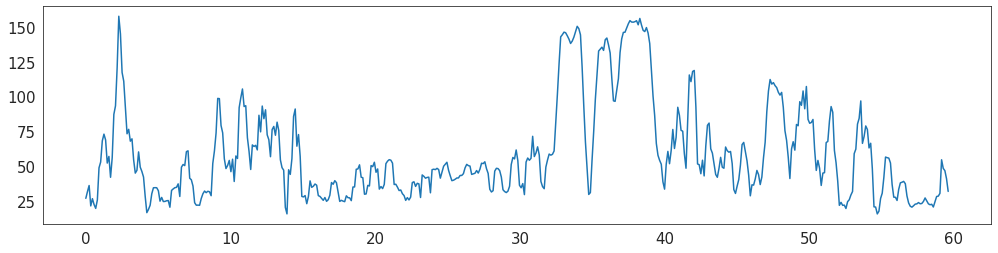

In [14]:
#spolight
size = 5
window = sp.signal.gaussian(M=size, std=5)
window /= window.sum()
filteredA = np.convolve(intensityDOF, window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensityDOF))], filteredA)
#ax.set_xlim(1,60)
F,A = compute_fft(intensityDOF, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)

0.569390332561174


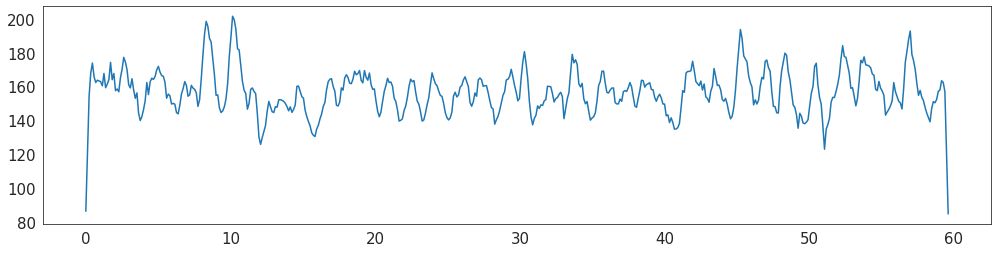

In [77]:
#spolight
# size = 5
# window = sp.signal.gaussian(M=size, std=5)
# window /= window.sum()
# filteredA = np.convolve(intensityDOF, window, mode='same')



# fig, ax = plt.subplots(1,1, figsize=(17,4))
# ax.plot([i/fps for i in range(0,len(intensityDOF))], filteredA)
# #ax.set_xlim(1,60)
# F,A = compute_fft(intensityDOF, fps)
# highestFreq = F[np.argmax(A[1:])+1]
# print(highestFreq)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.05024032346128006


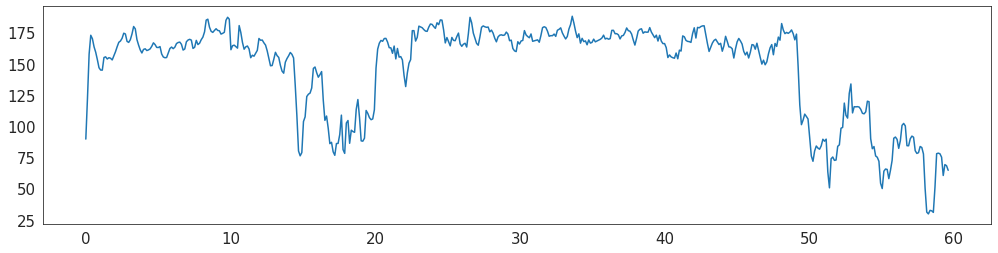

In [24]:
size = 5
window = sp.signal.gaussian(M=size, std=5)
window /= window.sum()
filteredA = np.convolve(intensityDOF, window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensityDOF))], filteredA)
#ax.set_xlim(1,60)
F,A = compute_fft(intensityDOF, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)

In [127]:
# lets check if the above result is random or are we doing well with the pixel selection
count = 0
concernedPixels = []
for pixelNo in range(0,pixel_t.shape[1]):
    
    size = 5
    window = sp.signal.gaussian(M=size, std=5)
    window /= window.sum()
    filteredA = np.convolve(pixel_t[:,pixelNo], window, mode='same')
    
    
    F,A = compute_fft(filteredA, fps)
    highestFreq = F[np.argmax(A[1:])+1]
    if highestFreq >= 0.5 and highestFreq <= 0.7:
        concernedPixels.append(pixelNo)
        #print("{} -- {:.2f}".format(pixelNo, highestFreq))
        count+=1
print("{} entried found".format(count))

52997 entried found


In [12]:
xx = np.isin(al,c)

In [22]:
xx.shape

(1440, 1080)

In [44]:
np.full((1440,1080),False)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

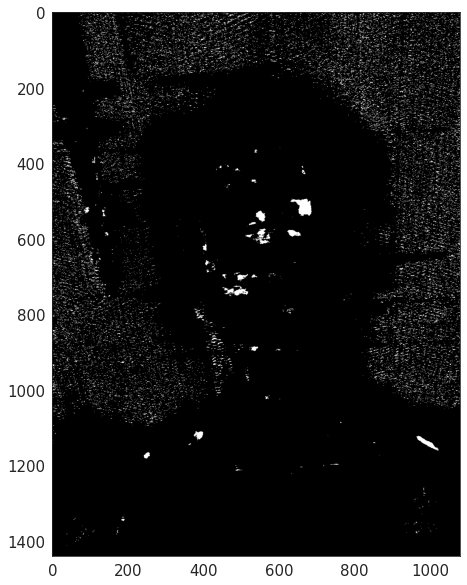

In [49]:
fig, ax = plt.subplots(1,1,figsize=(13,10))
ax.imshow(xx, cmap='gray')

In [37]:
print(xx[0,81])

True


0.3008677656424086


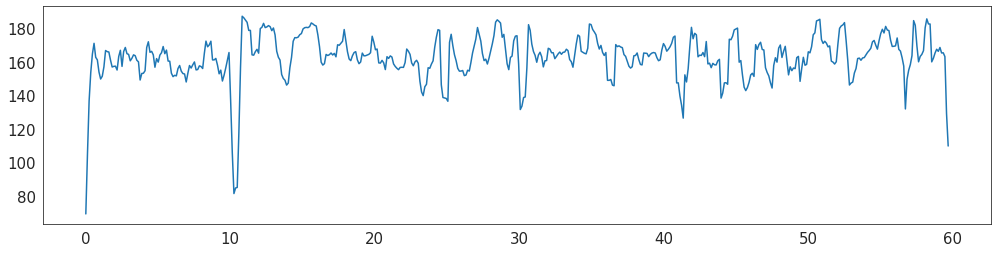

In [25]:
size = 5
window = sp.signal.gaussian(M=size, std=10)
window /= window.sum()
filteredA = np.convolve(np.array(intensity_xy), window, mode='same')

fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensity_xy))], filteredA)
#ax.set_xlim(0,180)
F,A = compute_fft(filteredA, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)